## INSTALL AND IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import requests # library to handle requests
from bs4 import BeautifulSoup

In [2]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.2.2


## GET DATA AND CLEAN

In [ ]:
# send the GET request
data = requests.get("https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego").text

In [ ]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [ ]:
# create a list to store neighborhood data
neighborhood_list = []

In [ ]:
# append the data into the list
for row in soup.find_all("div", class_="mw-parser-output")[0].findAll("li"):
    neighborhood_list.append(row.text)

In [ ]:
neighborhood_list

In [ ]:
neighborhood_list = [i.split('\n', 1)[0] for i in neighborhood_list]

In [ ]:
neighborhood_list

In [ ]:
# create a new DataFrame from the list
sd_df = pd.DataFrame({"Neighborhood": neighborhood_list})

In [ ]:
sd_df.head(130)

In [ ]:
# Cleaning DataFrame...
sd_df = sd_df.drop(sd_df.index[128:])

In [ ]:
sd_df.head(40)

In [ ]:
sd_df = sd_df.sort_values(by=['Neighborhood'])
sd_df = sd_df.reset_index(drop=True)

In [ ]:
sd_df

In [ ]:
#remove the 2 parenteses neighborhood

sd_df['Neighborhood'] = sd_df['Neighborhood'].apply(lambda x: x.replace(' (Midtown)', ''))

In [ ]:
sd_df['Neighborhood'] = sd_df['Neighborhood'].apply(lambda x: x.replace(' (Clairemont Mesa)', ''))

## GET THE GEO COORDINATES

In [ ]:
# function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, San Diego, California'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [ ]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [get_latlng(neighborhood) for neighborhood in sd_df["Neighborhood"].tolist()]

In [ ]:
coords

In [ ]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [ ]:
# merge the coordinates into the original dataframe
sd_df['Latitude'] = df_coords['Latitude']
sd_df['Longitude'] = df_coords['Longitude']

In [ ]:
#reload sd_df so there is no need to get coordinates again. This line works more like a break in the code.

In [3]:
sd_df = pd.read_csv("sd_df.csv")

In [4]:
# check the neighborhoods and the coordinates
print(sd_df.shape)
sd_df.head()

(128, 3)


,Neighborhood,Latitude,Longitude
0,Adams North,32.76336,-117.123612
1,Allied Gardens,32.79633,-117.094510
2,Alta Vista,32.69316,-117.067790
3,Azalea-Hollywood Park,32.73337,-117.101090
4,Balboa Park,32.72734,-117.147880


In [5]:
print(sd_df[sd_df['Neighborhood']=='Cortez Hill'].index.values)
print(sd_df[sd_df['Neighborhood']=='College Area'].index.values)
print(sd_df[sd_df['Neighborhood']=='North City'].index.values)

[31]
[25]
[79]


In [6]:
#later in the exercise I have found out that 3 neighborhoods were wrong on the map so I'm fixing here:

sd_df.loc[sd_df.index == 31, 'Latitude'] = "32.7222"
sd_df.loc[sd_df.index == 31, 'Longitude'] = "-117.1574"
sd_df.loc[sd_df.index == 25, 'Latitude'] = "32.7708"
sd_df.loc[sd_df.index == 25, 'Longitude'] = "-117.0698"
sd_df.loc[sd_df.index == 79, 'Latitude'] = "32.9732"
sd_df.loc[sd_df.index == 79, 'Longitude'] = "-117.2382"

In [7]:
sd_df.head(35)

,Neighborhood,Latitude,Longitude
0,Adams North,32.7634,-117.124
1,Allied Gardens,32.7963,-117.095
2,Alta Vista,32.6932,-117.068
3,Azalea-Hollywood Park,32.7334,-117.101
4,Balboa Park,32.7273,-117.148
5,Bankers Hill,32.7328,-117.196
6,Barrio Logan,32.6947,-117.138
7,Bay Ho,32.8278,-117.221
8,Bay Park,32.7908,-117.199
9,Bay Terraces,32.6917,-117.041


In [8]:
# save the DataFrame as CSV file
sd_df.to_csv("sd_df.csv", index=False)

## CREATE THE MAP OF SAN DIEGO

In [128]:
# get the coordinates of San Diego
address = 'San Diego, California'

geolocator = Nominatim(user_agent="my-app")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Diego, California {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Diego, California 32.7174202, -117.1627728.


In [11]:
# create map of San Diego using latitude and longitude values
map_sd = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(sd_df['Latitude'], sd_df['Longitude'], sd_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_sd) 
    
map_sd

In [ ]:
"""# save the map as HTML file
map_sd.save('map_sd.html')"""

## FOURSQURE API

In [227]:
# define Foursquare Credentials and Version
CLIENT_ID = 'your id'
CLIENT_SECRET = 'your secrete'
VERSION = '20180323'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: your id
CLIENT_SECRET:your secrete


In [25]:
radius = 3000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(sd_df['Latitude'], sd_df['Longitude'], sd_df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [26]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(11499, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Adams North,32.7634,-117.124,Pilgrimage of the Heart Yoga,32.763312,-117.123089,Yoga Studio
1,Adams North,32.7634,-117.124,Zia Gourmet Pizza,32.763270,-117.122567,Pizza Place
2,Adams North,32.7634,-117.124,Bine & Vine Bottle Shop,32.763538,-117.122052,Wine Shop
3,Adams North,32.7634,-117.124,Villainous Lair Gaming,32.763530,-117.121860,Gaming Cafe
4,Adams North,32.7634,-117.124,Villainous Lair Comics,32.763471,-117.124514,Comic Shop


In [27]:
venues_df.to_csv("venues_df.csv", index=False)

In [169]:
#I had a few memory issues here so I decided to import again the data and work as a new file!

In [170]:
venues_df = pd.read_csv("venues_df.csv") #run this line only if you starting the analysis from here.

In [171]:
sd_df = pd.read_csv("sd_df.csv")

In [172]:
venues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Adams North,100,100,100,100,100,100
Allied Gardens,98,98,98,98,98,98
Alta Vista,72,72,72,72,72,72
Azalea-Hollywood Park,87,87,87,87,87,87
Balboa Park,100,100,100,100,100,100
...,...,...,...,...,...,...
Torrey Preserve,90,90,90,90,90,90
University City,100,100,100,100,100,100
University Heights,100,100,100,100,100,100


In [173]:
v_df = venues_df.groupby(["Neighborhood"]).count()

In [174]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 347 uniques categories.


In [175]:
# print out the list of categories
venues_df['VenueCategory'].unique()[:25]

array(['Yoga Studio', 'Pizza Place', 'Wine Shop', 'Gaming Cafe',
       'Comic Shop', 'Vegetarian / Vegan Restaurant', 'Ice Cream Shop',
       'Coffee Shop', 'Beer Bar', 'Juice Bar', 'Cocktail Bar', 'Bakery',
       'Gelato Shop', 'Brewery', 'Ramen Restaurant', 'Bookstore',
       'Hawaiian Restaurant', 'Grocery Store', 'Japanese Restaurant',
       'Mexican Restaurant', 'Eastern European Restaurant',
       'Italian Restaurant', 'Café', 'Liquor Store',
       'Marijuana Dispensary'], dtype=object)

In [176]:
venues_list = venues_df['VenueCategory'].unique()

In [177]:
v_df = v_df['VenueCategory'].copy()

Text(0.5, 1.0, 'Total Number of Venues x Neighborhoods')

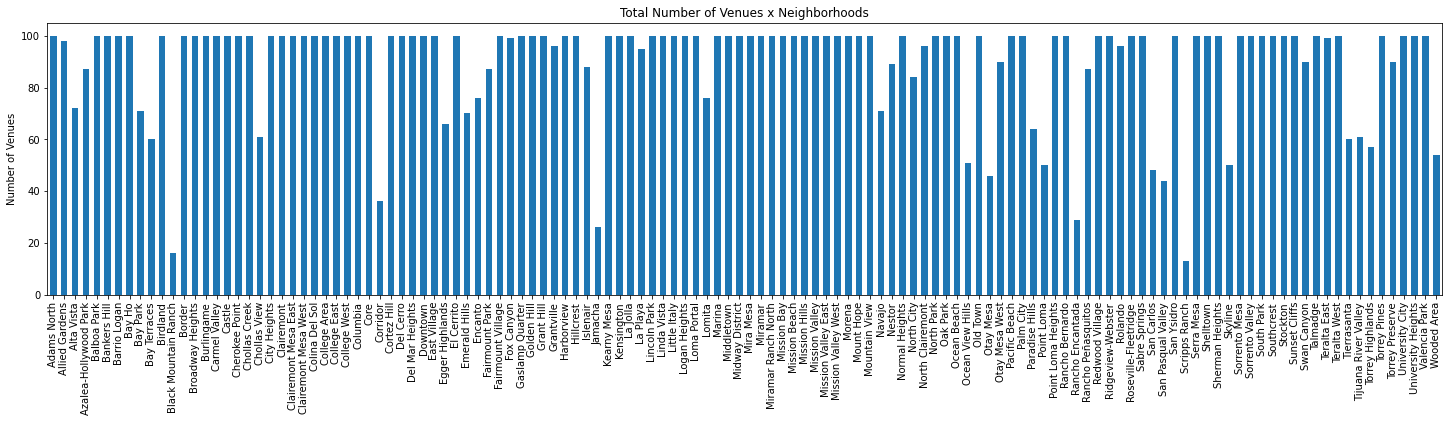

In [178]:
v_df.plot(kind='bar', figsize=(25, 5), width=0.6)

plt.xlabel('') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Total Number of Venues x Neighborhoods') # add title to the plot



## ANALYZE EACH NEIGHBORHOOD


In [179]:
# one hot encoding
sd_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sd_onehot['Neighborhood'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sd_onehot.columns[-1]] + list(sd_onehot.columns[:-1])
sd_onehot = sd_onehot[fixed_columns]

sd_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Alternative Healer,American Restaurant,Amphitheater,...,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
sd_onehot.shape

(11499, 347)

In [181]:
# Group by Neighborhood
sd_grouped = sd_onehot.groupby('Neighborhood').mean().reset_index()
sd_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Alternative Healer,American Restaurant,...,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adams North,0.00,0.000000,0.01,0.01,0.0,0.0,0.0,0.000000,0.020000,...,0.000000,0.0,0.0,0.000000,0.02,0.0,0.000000,0.00,0.01,0.00
1,Allied Gardens,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.010204,...,0.000000,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00
2,Alta Vista,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.013889,...,0.000000,0.0,0.0,0.000000,0.00,0.0,0.027778,0.00,0.00,0.00
3,Azalea-Hollywood Park,0.00,0.011494,0.00,0.00,0.0,0.0,0.0,0.000000,0.011494,...,0.011494,0.0,0.0,0.022989,0.00,0.0,0.011494,0.00,0.00,0.00
4,Balboa Park,0.03,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.050000,...,0.000000,0.0,0.0,0.010000,0.00,0.0,0.000000,0.00,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Torrey Preserve,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.011111,0.033333,...,0.000000,0.0,0.0,0.011111,0.00,0.0,0.000000,0.00,0.00,0.00
124,University City,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.00,0.0,0.000000,0.01,0.03,0.00
125,University Heights,0.00,0.000000,0.01,0.00,0.0,0.0,0.0,0.000000,0.050000,...,0.000000,0.0,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00
126,Valencia Park,0.00,0.010000,0.00,0.00,0.0,0.0,0.0,0.000000,0.010000,...,0.000000,0.0,0.0,0.000000,0.00,0.0,0.030000,0.00,0.00,0.00


In [182]:
sd_grouped.shape

(128, 347)

In [183]:
sd_grouped = sd_grouped.drop(['Zoo Exhibit', 'Intersection'], axis =1)

## OPTIMAL K MEANS

In [193]:
# Import required packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [194]:
data = sd_grouped.set_index('Neighborhood')

In [195]:
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

In [196]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

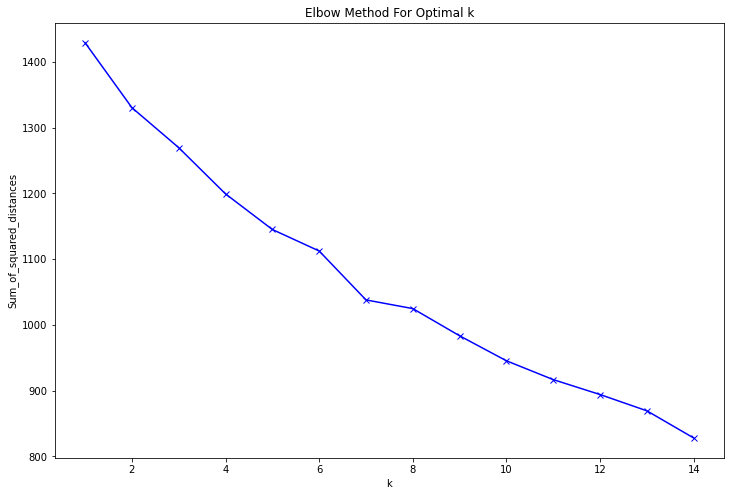

In [197]:
plt.figure(figsize=(12, 8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [198]:
from sklearn.metrics import silhouette_score

In [199]:
sil = []
kmax = range(2,15)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in kmax:
    kmeans = KMeans(n_clusters = k).fit(data_transformed)
    labels = kmeans.labels_
    sil.append(silhouette_score(data_transformed, labels, metric = 'euclidean'))

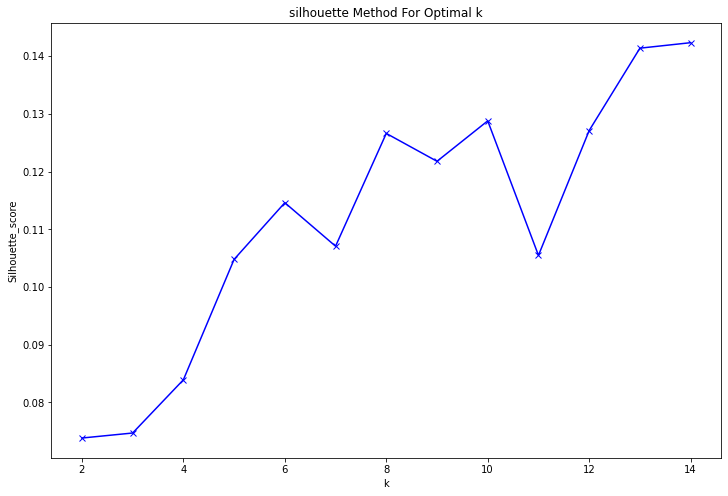

In [200]:
plt.figure(figsize=(12, 8))
plt.plot(kmax, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette_score')
plt.title('silhouette Method For Optimal k')
plt.show()

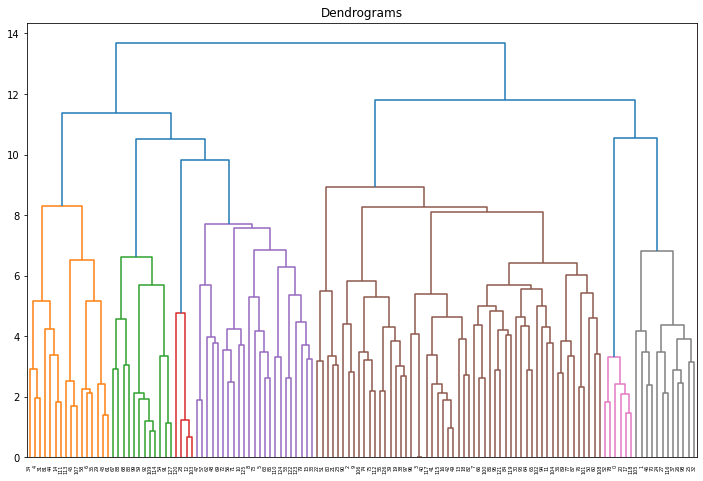

In [192]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(12,8))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(data_transformed, method='ward'))

In [201]:
num_top_venues = 10

for hood in sd_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sd_grouped[sd_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adams North----
                           venue  freq
0                    Coffee Shop  0.12
1                    Pizza Place  0.08
2                        Brewery  0.06
3                   Burger Joint  0.04
4           Marijuana Dispensary  0.03
5                     Taco Place  0.03
6                 Breakfast Spot  0.03
7                 Ice Cream Shop  0.03
8  Vegetarian / Vegan Restaurant  0.03
9                           Café  0.03


----Allied Gardens----
                venue  freq
0         Coffee Shop  0.06
1  Mexican Restaurant  0.06
2      Sandwich Place  0.06
3   Convenience Store  0.03
4         Pizza Place  0.03
5    Sushi Restaurant  0.03
6            Pharmacy  0.03
7  Italian Restaurant  0.03
8         Golf Course  0.02
9  Chinese Restaurant  0.02


----Alta Vista----
                 venue  freq
0   Mexican Restaurant  0.10
1               Bakery  0.06
2  Filipino Restaurant  0.04
3  Fried Chicken Joint  0.04
4    Convenience Store  0.04
5   Seafood Restaurant 

9           Pizza Place  0.03


----El Cerrito----
                   venue  freq
0     Mexican Restaurant  0.08
1  Vietnamese Restaurant  0.06
2          Grocery Store  0.05
3              Juice Bar  0.04
4     Chinese Restaurant  0.04
5            Pizza Place  0.03
6   Gym / Fitness Center  0.03
7      Convenience Store  0.03
8             Taco Place  0.03
9    American Restaurant  0.03


----Emerald Hills----
                  venue  freq
0    Mexican Restaurant  0.14
1     Convenience Store  0.06
2        Discount Store  0.04
3  Gym / Fitness Center  0.04
4        Sandwich Place  0.04
5              Pharmacy  0.04
6   Fried Chicken Joint  0.04
7           Pizza Place  0.04
8   American Restaurant  0.03
9      Asian Restaurant  0.03


----Encanto----
                  venue  freq
0              Pharmacy  0.07
1    Mexican Restaurant  0.05
2           Coffee Shop  0.05
3     Convenience Store  0.04
4  Gym / Fitness Center  0.04
5        Sandwich Place  0.04
6        Cosmetics Shop  0

9                   Hotel  0.03


----Mount Hope----
                  venue  freq
0    Mexican Restaurant  0.14
1           Coffee Shop  0.06
2        Sandwich Place  0.06
3           Pizza Place  0.03
4  Fast Food Restaurant  0.03
5  Gym / Fitness Center  0.03
6                  Park  0.03
7      Asian Restaurant  0.02
8                   Bar  0.02
9                  Café  0.02


----Mountain View----
                  venue  freq
0    Mexican Restaurant  0.17
1           Coffee Shop  0.06
2  Fast Food Restaurant  0.04
3  Gym / Fitness Center  0.03
4        Ice Cream Shop  0.03
5        Sandwich Place  0.03
6    Seafood Restaurant  0.02
7     Convenience Store  0.02
8           Supermarket  0.02
9                 Hotel  0.02


----Navajo----
                 venue  freq
0                Trail  0.10
1   Mexican Restaurant  0.07
2                 Park  0.04
3          Coffee Shop  0.04
4    Convenience Store  0.04
5             Mountain  0.04
6   Italian Restaurant  0.04
7        Groce

9          Donut Shop  0.03


----Swan Canyon----
                   venue  freq
0            Pizza Place  0.06
1     Mexican Restaurant  0.06
2  Vietnamese Restaurant  0.04
3   Fast Food Restaurant  0.03
4     Chinese Restaurant  0.03
5                   Café  0.03
6   Gym / Fitness Center  0.03
7         Sandwich Place  0.03
8      Convenience Store  0.03
9        Thai Restaurant  0.02


----Talmadge----
                   venue  freq
0  Vietnamese Restaurant  0.06
1            Pizza Place  0.04
2     Mexican Restaurant  0.04
3            Coffee Shop  0.04
4          Grocery Store  0.03
5                   Café  0.03
6           Burger Joint  0.03
7              Juice Bar  0.03
8     Italian Restaurant  0.03
9         Ice Cream Shop  0.03


----Teralta East----
                   venue  freq
0            Pizza Place  0.07
1         Ice Cream Shop  0.04
2  Vietnamese Restaurant  0.04
3          Grocery Store  0.04
4            Coffee Shop  0.04
5                   Café  0.03
6        

In [202]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [203]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sd_grouped['Neighborhood']

for ind in np.arange(sd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams North,Coffee Shop,Pizza Place,Brewery,Burger Joint,Ice Cream Shop,Liquor Store,Café,Beer Bar,Taco Place,Marijuana Dispensary
1,Allied Gardens,Coffee Shop,Sandwich Place,Mexican Restaurant,Pizza Place,Italian Restaurant,Convenience Store,Sushi Restaurant,Pharmacy,Burger Joint,Seafood Restaurant
2,Alta Vista,Mexican Restaurant,Bakery,Asian Restaurant,Convenience Store,Liquor Store,Coffee Shop,Fried Chicken Joint,Grocery Store,Seafood Restaurant,Filipino Restaurant
3,Azalea-Hollywood Park,Mexican Restaurant,Pizza Place,Café,Grocery Store,Fried Chicken Joint,Light Rail Station,Brewery,Convenience Store,Gym / Fitness Center,Italian Restaurant
4,Balboa Park,Coffee Shop,American Restaurant,Hotel,Park,Brewery,Italian Restaurant,Bar,Taco Place,Steakhouse,Mexican Restaurant


In [225]:
neighborhoods_venues_sorted.iloc[12]

Cluster Labels                              5
Neighborhood                           Border
1st Most Common Venue          Clothing Store
2nd Most Common Venue             Coffee Shop
3rd Most Common Venue                     Bar
4th Most Common Venue      Seafood Restaurant
5th Most Common Venue      Mexican Restaurant
6th Most Common Venue        Department Store
7th Most Common Venue          Chocolate Shop
8th Most Common Venue                 Brewery
9th Most Common Venue     Sporting Goods Shop
10th Most Common Venue             Taco Place
Name: 12, dtype: object

In [204]:
neighborhoods_venues_sorted.shape

(128, 11)

In [205]:
def return_most_common_venues2(row, num_top_venues):
    row_categories2 = row.iloc[1:]
    row_categories_sorted2 = row_categories2.sort_values(ascending=False)
    
    return row_categories_sorted2.values[0:num_top_venues]

In [209]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Neighborhood'] = sd_grouped['Neighborhood']

for ind in np.arange(sd_grouped.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues2(sd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams North,0.12,0.08,0.06,0.04,0.03,0.03,0.03,0.03,0.03,0.03
1,Allied Gardens,0.0612245,0.0612245,0.0612245,0.0306122,0.0306122,0.0306122,0.0306122,0.0306122,0.0204082,0.0204082
2,Alta Vista,0.0972222,0.0555556,0.0416667,0.0416667,0.0416667,0.0416667,0.0416667,0.0416667,0.0416667,0.0416667
3,Azalea-Hollywood Park,0.0574713,0.045977,0.045977,0.0344828,0.0344828,0.0344828,0.0344828,0.0344828,0.0229885,0.0229885
4,Balboa Park,0.06,0.05,0.05,0.05,0.04,0.03,0.03,0.03,0.03,0.03


In [226]:
neighborhoods_venues_sorted2.iloc[12]

Cluster Labels                 5
Neighborhood              Border
1st Most Common Venue        0.2
2nd Most Common Venue       0.07
3rd Most Common Venue       0.04
4th Most Common Venue       0.04
5th Most Common Venue       0.04
6th Most Common Venue       0.03
7th Most Common Venue       0.03
8th Most Common Venue       0.03
9th Most Common Venue       0.03
10th Most Common Venue      0.03
Name: 12, dtype: object

In [210]:
neighborhoods_venues_sorted2.shape

(128, 11)

## CLUSTER NEIGHBORHOODS

In [211]:
# set number of clusters
kclusters = 8

sd_grouped_clustering = sd_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sd_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 4, 4, 6, 6, 7, 2, 4, 4], dtype=int32)

In [212]:

# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
sd_grouped = sd_grouped.copy()

# add clustering labels
sd_grouped["Cluster Labels"] = kmeans.labels_

In [213]:
sd_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Alternative Healer,American Restaurant,Amphitheater,...,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Cluster Labels
0,Adams North,0.000000,0.01,0.01,0.0,0.0,0.0,0.0,0.020000,0.00,...,0.0,0.0,0.000000,0.02,0.0,0.000000,0.0,0.01,0.00,0
1,Allied Gardens,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.010204,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,2
2,Alta Vista,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.013889,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.027778,0.0,0.00,0.00,4
3,Azalea-Hollywood Park,0.011494,0.00,0.00,0.0,0.0,0.0,0.0,0.011494,0.00,...,0.0,0.0,0.022989,0.00,0.0,0.011494,0.0,0.00,0.00,4
4,Balboa Park,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.050000,0.01,...,0.0,0.0,0.010000,0.00,0.0,0.000000,0.0,0.00,0.01,6


In [214]:
# merge data to add latitude/longitude for each neighborhood
sd_grouped = sd_grouped.join(sd_df.set_index("Neighborhood"), on="Neighborhood")

print(sd_grouped.shape)
sd_grouped.head() # check the last columns! it will show the cluster label, latitude and longitude

(128, 348)


,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Alternative Healer,American Restaurant,Amphitheater,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Cluster Labels,Latitude,Longitude
0,Adams North,0.000000,0.01,0.01,0.0,0.0,0.0,0.0,0.020000,0.00,...,0.000000,0.02,0.0,0.000000,0.0,0.01,0.00,0,32.76336,-117.123612
1,Allied Gardens,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.010204,0.00,...,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,2,32.79633,-117.094510
2,Alta Vista,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.013889,0.00,...,0.000000,0.00,0.0,0.027778,0.0,0.00,0.00,4,32.69316,-117.067790
3,Azalea-Hollywood Park,0.011494,0.00,0.00,0.0,0.0,0.0,0.0,0.011494,0.00,...,0.022989,0.00,0.0,0.011494,0.0,0.00,0.00,4,32.73337,-117.101090
4,Balboa Park,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.050000,0.01,...,0.010000,0.00,0.0,0.000000,0.0,0.00,0.01,6,32.72734,-117.147880


In [215]:
# sort the results by Cluster Labels
print(sd_grouped.shape)
sd_grouped.sort_values(["Cluster Labels"], inplace=True)
sd_grouped

(128, 348)


,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,Alternative Healer,American Restaurant,Amphitheater,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Cluster Labels,Latitude,Longitude
0,Adams North,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.02,0.00,...,0.00,0.02,0.0,0.0,0.0,0.01,0.00,0,32.763360,-117.123612
96,Redwood Village,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.02,0.00,...,0.03,0.00,0.0,0.0,0.0,0.01,0.00,0,32.738445,-117.106310
20,City Heights,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.02,0.00,...,0.01,0.02,0.0,0.0,0.0,0.01,0.00,0,32.749690,-117.107150
111,South Park,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.01,0.01,...,0.01,0.00,0.0,0.0,0.0,0.01,0.02,0,32.727290,-117.129610
17,Cherokee Point,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.02,0.00,...,0.01,0.02,0.0,0.0,0.0,0.01,0.00,0,32.760820,-117.114122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,Logan Heights,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.01,...,0.01,0.00,0.0,0.0,0.0,0.00,0.00,7,32.711550,-117.144210
61,Marina,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.00,...,0.01,0.00,0.0,0.0,0.0,0.00,0.00,7,32.710960,-117.165600
35,East Village,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.00,...,0.01,0.00,0.0,0.0,0.0,0.00,0.00,7,32.711530,-117.149690
34,Downtown,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.04,0.01,...,0.01,0.00,0.0,0.0,0.0,0.00,0.00,7,32.719560,-117.155400


In [216]:
#save the cluster data for tableau analysis
sd_grouped.to_csv("sd_grouped.csv", index=False)

In [217]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sd_grouped['Latitude'], sd_grouped['Longitude'], sd_grouped['Neighborhood'], sd_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [218]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sd_merged = sd_df

# merge sd_grouped to add latitude/longitude for each neighborhood
sd_merged = sd_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sd_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams North,32.76336,-117.123612,0,Coffee Shop,Pizza Place,Brewery,Burger Joint,Ice Cream Shop,Liquor Store,Café,Beer Bar,Taco Place,Marijuana Dispensary
1,Allied Gardens,32.79633,-117.094510,2,Coffee Shop,Sandwich Place,Mexican Restaurant,Pizza Place,Italian Restaurant,Convenience Store,Sushi Restaurant,Pharmacy,Burger Joint,Seafood Restaurant
2,Alta Vista,32.69316,-117.067790,4,Mexican Restaurant,Bakery,Asian Restaurant,Convenience Store,Liquor Store,Coffee Shop,Fried Chicken Joint,Grocery Store,Seafood Restaurant,Filipino Restaurant
3,Azalea-Hollywood Park,32.73337,-117.101090,4,Mexican Restaurant,Pizza Place,Café,Grocery Store,Fried Chicken Joint,Light Rail Station,Brewery,Convenience Store,Gym / Fitness Center,Italian Restaurant
4,Balboa Park,32.72734,-117.147880,6,Coffee Shop,American Restaurant,Hotel,Park,Brewery,Italian Restaurant,Bar,Taco Place,Steakhouse,Mexican Restaurant


In [219]:
#save the common venue data for tableau analysis
sd_merged.to_csv("sd_merged.csv", index=False)

In [220]:
# add clustering labels
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)

sd_merged2 = sd_df

# merge sd_grouped to add latitude/longitude for each neighborhood
sd_merged2 = sd_merged2.join(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')

sd_merged2.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams North,32.76336,-117.123612,0,0.12,0.08,0.06,0.04,0.03,0.03,0.03,0.03,0.03,0.03
1,Allied Gardens,32.79633,-117.094510,2,0.0612245,0.0612245,0.0612245,0.0306122,0.0306122,0.0306122,0.0306122,0.0306122,0.0204082,0.0204082
2,Alta Vista,32.69316,-117.067790,4,0.0972222,0.0555556,0.0416667,0.0416667,0.0416667,0.0416667,0.0416667,0.0416667,0.0416667,0.0416667
3,Azalea-Hollywood Park,32.73337,-117.101090,4,0.0574713,0.045977,0.045977,0.0344828,0.0344828,0.0344828,0.0344828,0.0344828,0.0229885,0.0229885
4,Balboa Park,32.72734,-117.147880,6,0.06,0.05,0.05,0.05,0.04,0.03,0.03,0.03,0.03,0.03


In [221]:
#save the common venue (frequency) data for tableau analysis
sd_merged2.to_csv("sd_merged2.csv", index=False)

In [134]:
# all lines below were part of the original capstone project.
# I'm not revieweing those for this new publication because I have decided to use Tableau,
# but feel free to check the code!

## 1st Most Commom Venues - Overall Chart

In [ ]:
df_first = sd_merged[['Cluster Labels','1st Most Common Venue']]

In [ ]:
df_first.head(10)

In [ ]:
df_first = df_first.groupby(['1st Most Common Venue']).count()

In [ ]:
df_first.plot(kind='bar', figsize=(15, 5), width=0.7)

plt.xlabel('') # add to x-label to the plot
plt.ylabel('') # add y-label to the plot
plt.title('1st Most Commom Venues') # add title to the plot

## 2nd Most Commom Venues - Overall Chart

In [ ]:
df_second = sd_merged[['Cluster Labels','2nd Most Common Venue']]

In [ ]:
df_second.head(10)

In [ ]:
df_second = df_second.groupby(['2nd Most Common Venue']).count()

In [ ]:
df_second.plot(kind='bar', figsize=(15, 5), width=0.7, color="red")

plt.xlabel('') # add to x-label to the plot
plt.ylabel('') # add y-label to the plot
plt.title('2nd Most Commom Venues') # add title to the plot

## 3rd Most Commom Venues - Overall Chart

In [ ]:
df_third = sd_merged[['Cluster Labels','3rd Most Common Venue']]

In [ ]:
df_third.head(10)

In [ ]:
df_third = df_third.groupby(['3rd Most Common Venue']).count()

In [ ]:
df_third.plot(kind='bar', figsize=(15, 5), width=0.7)

plt.xlabel('') # add to x-label to the plot
plt.ylabel('') # add y-label to the plot
plt.title('2nd Most Commom Venues') # add title to the plot

## EXAMINE CLUSTERS

## CLUSTER 0

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 0]

In [ ]:
sd_grouped.loc[sd_grouped['Cluster Labels'] == 0]

In [ ]:
sd_zero = sd_grouped.loc[sd_grouped['Cluster Labels'] == 0]

In [ ]:
sd_zero = sd_zero.set_index(['Neighborhood'])

In [ ]:
sd_zero = sd_zero.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_zero = sd_zero.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_zero = sd_zero.transpose()

## CLUSTER 1

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 1]

In [ ]:
sd_grouped.loc[sd_grouped['Cluster Labels'] == 1]

In [ ]:
sd_um = sd_grouped.loc[sd_grouped['Cluster Labels'] == 1]

In [ ]:
sd_um = sd_um.set_index(['Neighborhood'])

In [ ]:
sd_um = sd_um.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_um = sd_um.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_um = sd_um.transpose()

## CLUSTER 2

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 2]

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 2]

In [ ]:
sd_dois = sd_merged2.loc[sd_merged2['Cluster Labels'] == 2]

In [ ]:
sd_dois = sd_dois.set_index(['Neighborhood'])

In [ ]:
sd_dois = sd_dois.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_dois = sd_dois.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_dois = sd_dois.transpose()

## CLUSTER 3

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 3]

In [ ]:
sd_grouped.loc[sd_grouped['Cluster Labels'] == 3]

In [ ]:
sd_tres = sd_grouped.loc[sd_grouped['Cluster Labels'] == 3]

In [ ]:
sd_tres = sd_tres.set_index(['Neighborhood'])

In [ ]:
sd_tres = sd_tres.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_tres = sd_tres.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_tres = sd_tres.transpose()

## CLUSTER 4

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 4]

In [ ]:
sd_grouped.loc[sd_grouped['Cluster Labels'] == 4]

In [ ]:
sd_quatro = sd_grouped.loc[sd_grouped['Cluster Labels'] == 4]

In [ ]:
sd_quatro = sd_quatro.set_index(['Neighborhood'])

In [ ]:
sd_quatro = sd_quatro.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_quatro = sd_quatro.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_quatro = sd_quatro.transpose()

## CLUSTER 5

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 5]

In [ ]:
sd_grouped.loc[sd_grouped['Cluster Labels'] == 5]

In [ ]:
sd_cinco = sd_grouped.loc[sd_grouped['Cluster Labels'] == 5]

In [ ]:
sd_cinco = sd_cinco.set_index(['Neighborhood'])

In [ ]:
sd_cinco = sd_cinco.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_cinco = sd_cinco.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_cinco = sd_cinco.transpose()

## CLUSTER 6

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 6]

In [ ]:
sd_grouped.loc[sd_grouped['Cluster Labels'] == 6]

In [ ]:
sd_seis = sd_grouped.loc[sd_grouped['Cluster Labels'] == 6]

In [ ]:
sd_seis = sd_seis.set_index(['Neighborhood'])

In [ ]:
sd_seis = sd_seis.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_seis = sd_seis.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_seis = sd_seis.transpose()

## CLUSTER 7

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 7]

In [ ]:
sd_grouped.loc[sd_grouped['Cluster Labels'] == 7]

In [ ]:
sd_sete = sd_grouped.loc[sd_grouped['Cluster Labels'] == 7]

In [ ]:
sd_sete = sd_sete.set_index(['Neighborhood'])

In [ ]:
sd_sete = sd_sete.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_sete = sd_sete.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_sete = sd_sete.transpose()

## CLUSTER 8

In [ ]:
sd_merged.loc[sd_merged['Cluster Labels'] == 8]

In [ ]:
sd_grouped.loc[sd_grouped['Cluster Labels'] == 8]

In [ ]:
sd_oito = sd_grouped.loc[sd_grouped['Cluster Labels'] == 0]

In [ ]:
sd_oito = sd_oito.set_index(['Neighborhood'])

In [ ]:
sd_oito = sd_oito.drop(['Latitude', 'Longitude', 'Cluster Labels'], axis=1)

In [ ]:
sd_oito = sd_oito.replace(0,np.nan).dropna(axis=1,how="all")

In [ ]:
sd_oito = sd_oito.transpose()

## NEIGHBORHOOD ANALYSIS

## Old Town

In [ ]:
df_oldtown = sd_grouped.iloc[50]

In [ ]:
df_oldtown = df_oldtown.replace(0, np.nan)
df_oldtown = df_oldtown.dropna(how='all', axis=0)
df_oldtown = df_oldtown.replace(np.nan, 0)

In [ ]:
df_oldtown = df_oldtown.reset_index()

In [ ]:
df_oldtown.columns = df_oldtown.iloc[0]

In [ ]:
df_oldtown = df_oldtown.drop(df_oldtown.index[0])

In [ ]:
df_oldtown = df_oldtown.set_index(['Neighborhood'])

In [ ]:
df_oldtown

In [ ]:
df_oldtown = df_oldtown.drop(df_oldtown.index[[-1, -2, -3]])

In [ ]:
df_oldtown.plot(kind='bar', figsize=(15, 5), width=0.7)

plt.xlabel('') # add to x-label to the plot
plt.ylabel('Frequency') # add y-label to the plot
plt.title('Most Commom Venues in Oldtown') # add title to the plot

## Downtown

In [ ]:
df_dtown = sd_grouped.iloc[4]

In [ ]:
df_ftown = df_dtown.replace(0, np.nan)
df_dtown = df_dtown.dropna(how='all', axis=0)
df_dtown = df_dtown.replace(np.nan, 0)

In [ ]:
df_dtown = df_dtown.reset_index()

In [ ]:
df_dtown.columns = df_dtown.iloc[0]

In [ ]:
df_dtown = df_dtown.drop(df_dtown.index[0])

In [ ]:
df_dtown = df_dtown.set_index(['Neighborhood'])

In [ ]:
df_dtown

In [ ]:
df_dtown = df_dtown.drop(df_dtown.index[[-1, -2, -3]])

In [ ]:
df_dtown.plot(kind='bar', figsize=(100, 25), width=0.7)

plt.xlabel('') # add to x-label to the plot
plt.ylabel('Frequency') # add y-label to the plot
plt.title('Most Commom Venues in Downtown') # add title to the plot